In [ ]:
# !pip install catboost
# !pip install xgboost

In [1]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from utils import plot_calibration_curve, plot_overlap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functools import partial
import concurrent.futures
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import tqdm
import ast

RANDOM_SEED = 42

# Load Data

In [2]:
partial_df = pd.read_csv('Final_Data/partial_feature_df.csv', index_col=0)
full_df = pd.read_csv('Final_Data/full_feature_df.csv', index_col=0)

df, path2save = [(full_df, "ate_full_df.csv"), (partial_df, "ate_partial_df.csv")][0]

# Models

In [3]:
with open('hp_tunning.pkl', 'rb') as f:
    hp_tunning = pickle.load(f)

lr_model_class = partial(LogisticRegression, **hp_tunning['lr']['hyper_params'], random_state=RANDOM_SEED)
rf_model_class = partial(RandomForestClassifier, **hp_tunning['rf']['hyper_params'], random_state=RANDOM_SEED)
gb_model_class = partial(GradientBoostingClassifier, **hp_tunning['gb']['hyper_params'], random_state=RANDOM_SEED)
xgb_model_class = partial(xgb.XGBClassifier, **hp_tunning['xgb']['hyper_params'], random_state=RANDOM_SEED)

# Propensity Score

In [4]:
def estemite_e(df, model):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    
    X = df.drop(columns=['T', 'Y'])
    y = df['T']
    
    if type(model).__name__ in ["LogisticRegression", "SVC", "RandomForestClassifier","GradientBoostingClassifier", "XGBClassifier"]:
        dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
        X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)
    
    if type(model).__name__ == ['LogisticRegression', 'SVC']:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    model.fit(X, y)
    
    print(type(model).__name__)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return y_pred_proba

############################ Propensity eval ################################
propensity_score_lr = estemite_e(df, lr_model_class())
propensity_score_rf = estemite_e(df, rf_model_class())
propensity_score_gb = estemite_e(df, gb_model_class())
propensity_score_xgb = estemite_e(df, xgb_model_class())

LogisticRegression
RandomForestClassifier
GradientBoostingClassifier
XGBClassifier


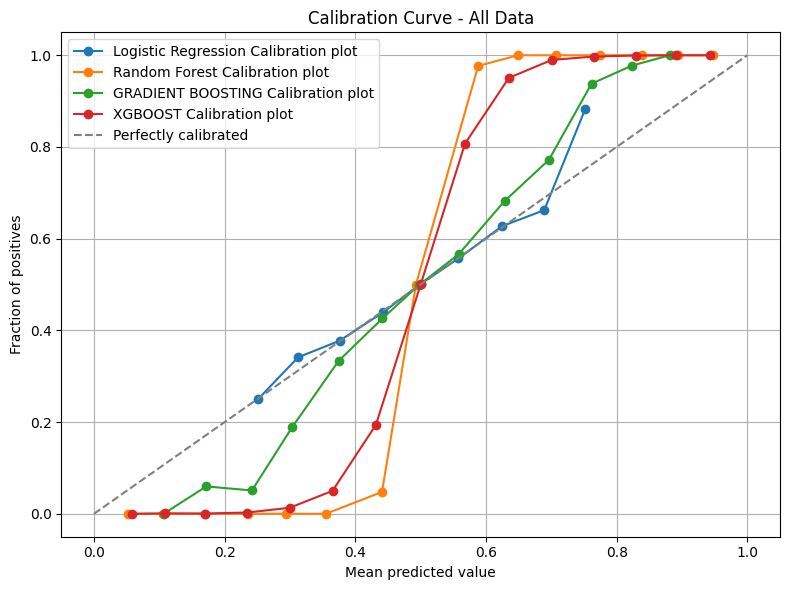

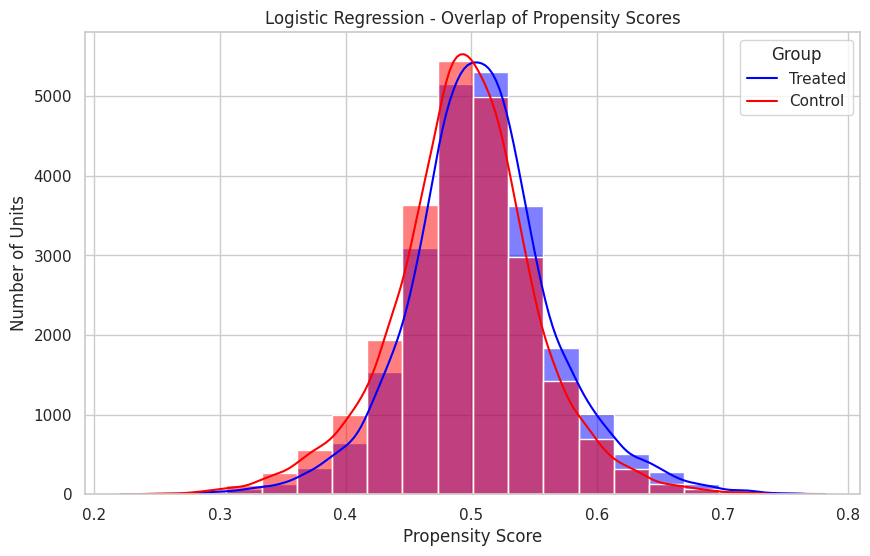

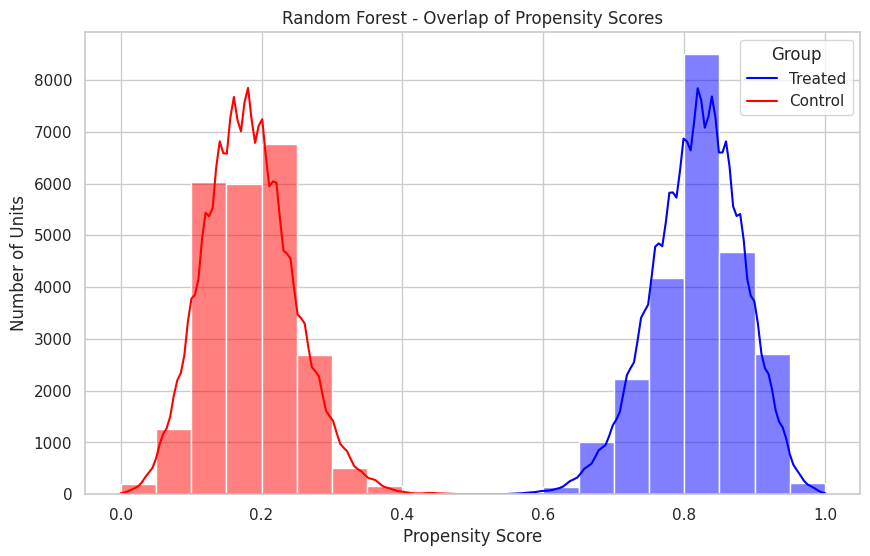

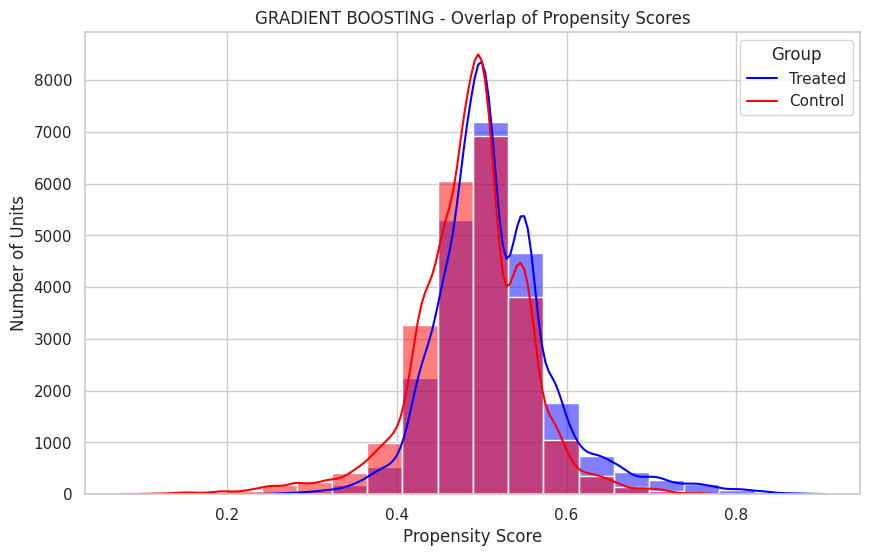

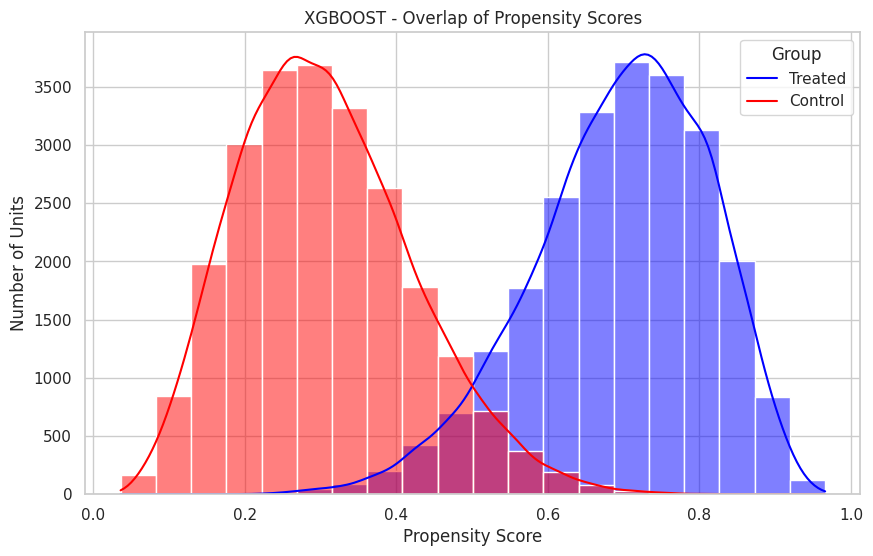

In [5]:
plot_calibration_curve(df['T'], {'Logistic Regression': propensity_score_lr,
                                        'Random Forest': propensity_score_rf,
                                        'GRADIENT BOOSTING': propensity_score_gb,
                                        'XGBOOST': propensity_score_xgb,
                                        })

plot_overlap(df['T'], propensity_score_lr, model_name='Logistic Regression')
plot_overlap(df['T'], propensity_score_rf, model_name='Random Forest')
plot_overlap(df['T'], propensity_score_gb, model_name='GRADIENT BOOSTING')
plot_overlap(df['T'], propensity_score_xgb, model_name='XGBOOST')

# IPW

In [6]:
def IPW_ATE(df, propensity_score):
    n = len(df)
    y1 = df.loc[df['T'] == 1, 'Y']
    y0 = df.loc[df['T'] == 0, 'Y']

    assert n == len(y1) + len(y0), "Mismatch"

    ATT_ipw = (sum(y1 / propensity_score[df['T'] == 1]) - sum(y0 / (1 - propensity_score[df['T'] == 0]))) / n

    return ATT_ipw

#############################################################################
IPW_ATE_df = IPW_ATE(df, propensity_score_lr)

ATE_df = pd.DataFrame({'Method': ['IPW'], 'ATE': [IPW_ATE_df]})
ATE_df

,Method,ATE
0,IPW,0.183321


# Find Best Model For S/T-Learner

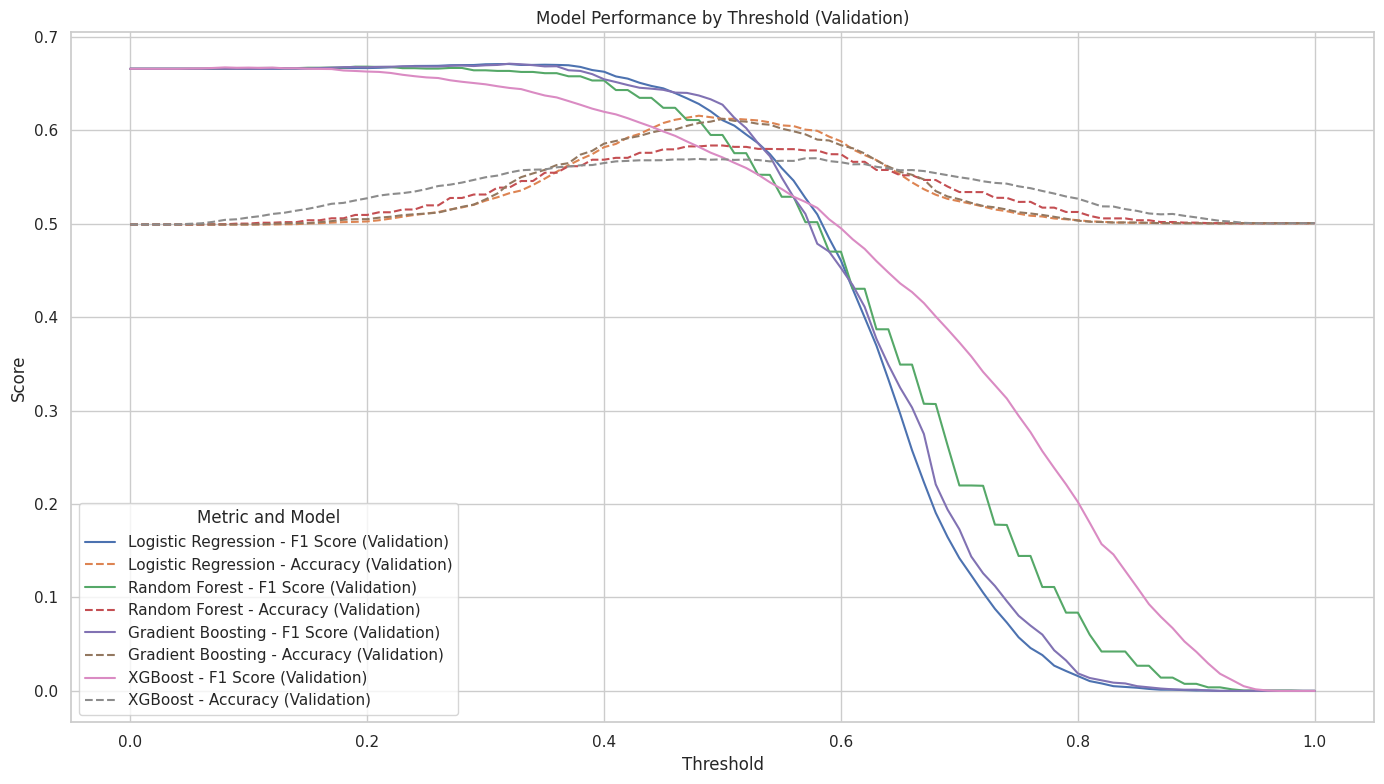

,Model,Best Threshold,Best F1 Score (Validation),Best Accuracy (Validation),Test F1 Score,Test Accuracy
0,Logistic Regression,0.32,0.671126,0.615774,0.666168,0.528666
1,Random Forest,0.19,0.668285,0.583888,0.664233,0.504804
2,Gradient Boosting,0.32,0.671473,0.612396,0.665038,0.536797
3,XGBoost,0.08,0.667516,0.570267,0.662364,0.497308


In [9]:
def evaluate_model_with_threshold(df, model, test_size=0.2, validation_size=0.2, random_state=0):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    X = df.drop(columns=['Y'])
    y = df['Y']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + validation_size), random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state=random_state)
    
    if type(model).__name__ in ["LogisticRegression", "SVC", "RandomForestClassifier", "GradientBoostingClassifier", "XGBClassifier"]:
        X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
        X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
        X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
        
        X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
        X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    if type(model).__name__ in ['LogisticRegression', 'SVC']:
        scaler = MinMaxScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]  
    
    thresholds = np.arange(0.0, 1.01, 0.01)
    f1_scores = []
    accuracies = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1_scores.append(f1_score(y_val, y_pred))
        accuracies.append(accuracy_score(y_val, y_pred))

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    best_accuracy = max(accuracies)

    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_prob_test >= best_threshold).astype(int)
    test_f1 = f1_score(y_test, y_pred_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    metrics = {
        'Best Threshold': best_threshold,
        'Best F1 Score (Validation)': best_f1,
        'Best Accuracy (Validation)': best_accuracy,
        'Test F1 Score': test_f1,
        'Test Accuracy': test_accuracy,
        'F1 Scores (Validation)': f1_scores,
        'Accuracies (Validation)': accuracies,
        'Thresholds': thresholds
    }

    return metrics

#############################################################################
models = {
    "Logistic Regression": lr_model_class(),
    "Random Forest": rf_model_class(),
    "Gradient Boosting": gb_model_class(),
    "XGBoost": xgb_model_class()
}

all_metrics = {}
for model_name, model in models.items():
    metrics = evaluate_model_with_threshold(df, model)
    all_metrics[model_name] = metrics

plt.figure(figsize=(14, 8))

for model_name, metrics in all_metrics.items():
    plt.plot(metrics['Thresholds'], metrics['F1 Scores (Validation)'], label=f'{model_name} - F1 Score (Validation)')
    plt.plot(metrics['Thresholds'], metrics['Accuracies (Validation)'], label=f'{model_name} - Accuracy (Validation)', linestyle='--')

plt.title('Model Performance by Threshold (Validation)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(title='Metric and Model')
plt.tight_layout()
plt.show()

th_df = pd.DataFrame({
    'Model': list(all_metrics.keys()),
    'Best Threshold': [metrics['Best Threshold'] for metrics in all_metrics.values()],
    'Best F1 Score (Validation)': [metrics['Best F1 Score (Validation)'] for metrics in all_metrics.values()],
    'Best Accuracy (Validation)': [metrics['Best Accuracy (Validation)'] for metrics in all_metrics.values()],
    'Test F1 Score': [metrics['Test F1 Score'] for metrics in all_metrics.values()],
    'Test Accuracy': [metrics['Test Accuracy'] for metrics in all_metrics.values()]
})

display(th_df)

# S-Learner

In [13]:
def SLearner_ATE(df, model, th=0.5, test_size=0.2):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])  
    y = df['Y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

    if type(model).__name__ in ["LogisticRegression", "RandomForestClassifier", "GradientBoostingClassifier", "XGBClassifier"]:
        dummied_train_df = pd.get_dummies(X_train[categorical_cols], prefix=categorical_cols).astype(int)
        dummied_test_df = pd.get_dummies(X_test[categorical_cols], prefix=categorical_cols).astype(int)

        X_train = pd.concat([X_train.drop(categorical_cols, axis=1), dummied_train_df], axis=1)
        X_test = pd.concat([X_test.drop(categorical_cols, axis=1), dummied_test_df], axis=1)


    if type(model).__name__ in ['LogisticRegression']:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    if type(model).__name__ in ['CatBoostClassifier']:
        model.fit(X_train, y_train, cat_features=categorical_cols)
    else:
        model.fit(X_train, y_train)

    x1 = X_test.copy()
    x0 = X_test.copy()
    x1['T'], x0['T'] = 1, 0

    y1_pred = (np.array(model.predict_proba(x1)[:, 1]) > th).astype(float)
    y0_pred = (np.array(model.predict_proba(x0)[:, 1]) > th).astype(float)

    ATE = (y1_pred - y0_pred).mean()
    return ATE

#############################################################################
model_th = th_df[th_df['Model']=='Logistic Regression']['Best Threshold'].iloc[0]
SLearner_ATE_df = SLearner_ATE(df, model=lr_model_class(), th=model_th)
new_row = pd.DataFrame({'Method': ['S-learner'], 'ATE': [SLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.183321
1,S-learner,0.125963


# T-Learner

In [19]:
def TLearner_ATE(df, model0, model1, th=0.5):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    X = df.drop(columns=['Y', 'T']).reset_index(drop=True) 
    y = df['Y'].reset_index(drop=True)
    treatment = df['T'].reset_index(drop=True)

    X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.2, random_state=42)

    if type(model1).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']:
        dummied_train_df = pd.get_dummies(X_train[categorical_cols], prefix=categorical_cols).astype(int)
        dummied_test_df = pd.get_dummies(X_test[categorical_cols], prefix=categorical_cols).astype(int)

        X_train = pd.concat([X_train.drop(categorical_cols, axis=1), dummied_train_df], axis=1)
        X_test = pd.concat([X_test.drop(categorical_cols, axis=1), dummied_test_df], axis=1)

    if type(model1).__name__ == 'LogisticRegression':
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    X1_train = X_train[treatment_train == 1]
    y1_train = y_train[treatment_train == 1]
    X0_train = X_train[treatment_train == 0]
    y0_train = y_train[treatment_train == 0]

    model1.fit(X1_train, y1_train)
    model0.fit(X0_train, y0_train)

#     y1_pred = model1.predict(X_test)
#     y0_pred = model0.predict(X_test)
    y1_pred = (np.array(model1.predict_proba(X_test)[:, 1]) > th).astype(float)
    y0_pred = (np.array(model0.predict_proba(X_test)[:, 1]) > th).astype(float)

    ATE = (y1_pred.mean() - y0_pred.mean())
    return ATE
#############################################################################
model_th = th_df[th_df['Model']=='Logistic Regression']['Best Threshold'].iloc[0]
SLearner_ATE_df = TLearner_ATE(df, model0=lr_model_class(), model1=lr_model_class(), th=model_th)
print("Estimated ATE (Logistic Regression):", SLearner_ATE_df)

model_th = th_df[th_df['Model']=='Random Forest']['Best Threshold'].iloc[0]
SLearner_ATE_df = TLearner_ATE(df, model0=rf_model_class(), model1=rf_model_class(), th=model_th)
print("Estimated ATE (Random Forest):", SLearner_ATE_df)

model_th = th_df[th_df['Model']=='Gradient Boosting']['Best Threshold'].iloc[0]
SLearner_ATE_df = TLearner_ATE(df, model0=gb_model_class(), model1=gb_model_class(), th=model_th)
print("Estimated ATE (Gradient Boosting):", SLearner_ATE_df)

model_th = th_df[th_df['Model']=='XGBoost']['Best Threshold'].iloc[0]
SLearner_ATE_df = TLearner_ATE(df, model0=xgb_model_class(), model1=xgb_model_class(), th=model_th)
print("Estimated ATE (XGBoost):", SLearner_ATE_df)

model_th = th_df[th_df['Model']=='Logistic Regression']['Best Threshold'].iloc[0]
TLearner_ATE_df = TLearner_ATE(df, model0=lr_model_class(), model1=lr_model_class(), th=model_th)

new_row = pd.DataFrame({'Method': ['T-learner'], 'ATE': [TLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

Estimated ATE (Logistic Regression): 0.12131770668356034
Estimated ATE (Random Forest): 0.034209692746278164
Estimated ATE (Gradient Boosting): 0.1717875620314644
Estimated ATE (XGBoost): 0.013831696758526024


,Method,ATE
0,IPW,0.183321
1,S-learner,0.125963
2,T-learner,0.121318


# Matching

In [20]:
def Matching_ATE(df, epsilon=0.1):
    df_norm = df.copy()
    df_norm = df_norm.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    categorical_cols = df_norm.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_norm.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['Y', 'T']]

    dummied_df_X = pd.get_dummies(df_norm[categorical_cols], drop_first=True)
    X = pd.concat([df_norm[numerical_cols], dummied_df_X, df_norm[['T', 'Y']]], axis=1)

    scaler = MinMaxScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    X1 = X[X['T'] == 1].reset_index(drop=True)
    X0 = X[X['T'] == 0].reset_index(drop=True)

    # Use NearestNeighbors to find closest matches
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean').fit(X0.drop(columns=['T', 'Y']).values)
    distances, min_indices = nbrs.kneighbors(X1.drop(columns=['T', 'Y']).values)

    # Filter for valid matches
    valid_matches = distances.flatten() < epsilon
    valid_min_indices = min_indices.flatten()[valid_matches]
    counts = np.bincount(valid_min_indices)
    unique_indices = np.where(counts == 1)[0]

    # Keep only treated indices that correspond to unique matches
    treated_indices_with_unique_matches = np.where(valid_matches)[0][np.isin(valid_min_indices, unique_indices)]

    if len(treated_indices_with_unique_matches) > 0:
        treated_Y_values = X1['Y'].values[treated_indices_with_unique_matches]
        control_Y_values = X0.loc[valid_min_indices[np.isin(valid_min_indices, unique_indices)], 'Y'].values

        # Calculate ATE
        ATE = treated_Y_values - control_Y_values
        return ATE.mean()
    else:
        return np.nan

#############################################################################
epsilon = 0.1  
matching_ATE = Matching_ATE(df, epsilon)

new_row = pd.DataFrame({'Method': ['Matching'], 'ATE': [matching_ATE]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.183321
1,S-learner,0.125963
2,T-learner,0.121318
3,Matching,0.193833


# Doubly - Robust

In [21]:
def DR_ATE(df, model0, model1, propensity_score, th=0.5, test_size=0.2, random_state=42):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])
    y = df['Y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    if type(model1).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']:
        dummied_train_df_X = pd.get_dummies(X_train[categorical_cols], prefix=categorical_cols).astype(int)
        X_train = pd.concat([X_train.drop(categorical_cols, axis=1), dummied_train_df_X], axis=1)

        dummied_test_df_X = pd.get_dummies(X_test[categorical_cols], prefix=categorical_cols).astype(int)
        X_test = pd.concat([X_test.drop(categorical_cols, axis=1), dummied_test_df_X], axis=1)

    if type(model1).__name__ in ['LogisticRegression']:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    X_train_1 = X_train.loc[X_train['T'] == 1].drop(columns=['T'])
    y_train_1 = y_train.loc[X_train['T'] == 1]
    X_train_0 = X_train.loc[X_train['T'] == 0].drop(columns=['T'])
    y_train_0 = y_train.loc[X_train['T'] == 0]

    if type(model1).__name__ in ['CatBoostClassifier']:
        model1.fit(X_train_1, y_train_1, cat_features=categorical_cols)
        model0.fit(X_train_0, y_train_0, cat_features=categorical_cols)
    else:
        model1.fit(X_train_1, y_train_1)
        model0.fit(X_train_0, y_train_0)

    propensity_score_test = propensity_score[X_test.index]

    y1_pred_prob = model1.predict_proba(X_test.drop(columns=['T']))[:, 1]
    y0_pred_prob = model0.predict_proba(X_test.drop(columns=['T']))[:, 1]

    y1_pred = (y1_pred_prob > th).astype(float)
    y0_pred = (y0_pred_prob > th).astype(float)

    g1 = y1_pred + (X_test['T'].to_numpy() / propensity_score_test) * (y_test - y1_pred)
    g0 = y0_pred + ((1 - X_test['T'].to_numpy()) / (1 - propensity_score_test)) * (y_test - y0_pred)

    return (g1 - g0).mean()

#############################################################################
model_th = th_df[th_df['Model']=='Logistic Regression']['Best Threshold'].iloc[0]
DR_ATE_df = DR_ATE(df, model0=lr_model_class(), model1=lr_model_class(), propensity_score=propensity_score_lr, th=model_th)

new_row = pd.DataFrame({'Method': ['Doubly Robust'], 'ATE': [DR_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.183321
1,S-learner,0.125963
2,T-learner,0.121318
3,Matching,0.193833
4,Doubly Robust,0.173728


# CI

In [22]:
def bootstrap_iter(sample_df, method, propensity_score, model_class, th):
    """
    This function runs a single bootstrap iteration.
    """
    if method == "IPW":
        result = IPW_ATE(sample_df, propensity_score)
    elif method == "S-learner":
        result = SLearner_ATE(sample_df, model_class(), th=th)
    elif method == "T-learner":
        result = TLearner_ATE(sample_df, model_class(), model_class(), th=th)
    elif method == "Matching":
        result = Matching_ATE(sample_df, epsilon=0.1)
    elif method == "Doubly Robust":
        result = DR_ATE(sample_df, model_class(), model_class(), propensity_score, th=th)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return result

def calc_bootstrap_CI(df, method, propensity_score, model_class ,th=0.5):
    df['propensity_score'] = propensity_score
    print(method)

    ATEs = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        
        for _ in tqdm.tqdm(range(300)):  
            sample_df = df.sample(n=len(df), replace=True)
            sample_propensity_score = sample_df['propensity_score'].to_numpy()
            sample_df = sample_df.drop(columns='propensity_score')

            futures.append(executor.submit(bootstrap_iter, sample_df, method, sample_propensity_score, model_class, th))
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures)):
            ATEs.append(future.result())
    
    lower_bound = round(np.percentile(ATEs, 2.5), 3)
    upper_bound = round(np.percentile(ATEs, 97.5), 3)
    
    return [lower_bound, upper_bound]

#############################################################################
model_th = th_df[th_df['Model']=='Logistic Regression']['Best Threshold'].iloc[0]
ATE_df['CI'] = ATE_df['Method'].apply(lambda method: calc_bootstrap_CI(df, method, propensity_score_lr, lr_model_class, th=model_th))
ATE_df

IPW


100% 300/300 [00:08<00:00, 35.46it/s]
300it [00:00, 35019.65it/s]


S-learner


100% 300/300 [02:44<00:00,  1.82it/s]
300it [16:36,  3.32s/it]


T-learner


100% 300/300 [02:26<00:00,  2.05it/s]
300it [20:55,  4.18s/it]


Matching


100% 300/300 [00:03<00:00, 79.42it/s] 
300it [03:22,  1.48it/s]


Doubly Robust


100% 300/300 [02:38<00:00,  1.90it/s]
300it [22:22,  4.47s/it]


,Method,ATE,CI
0,IPW,0.183321,"[0.171, 0.194]"
1,S-learner,0.125963,"[0.109, 0.146]"
2,T-learner,0.121318,"[0.099, 0.148]"
3,Matching,0.193833,"[0.167, 0.227]"
4,Doubly Robust,0.173728,"[0.151, 0.203]"


In [23]:
ATE_df.to_csv(f'Final_Data/{path2save}')

In [24]:
ate_full_df = pd.read_csv('Final_Data/ate_full_df.csv', index_col=0)
ate_partial_df = pd.read_csv('Final_Data/ate_partial_df.csv', index_col=0)

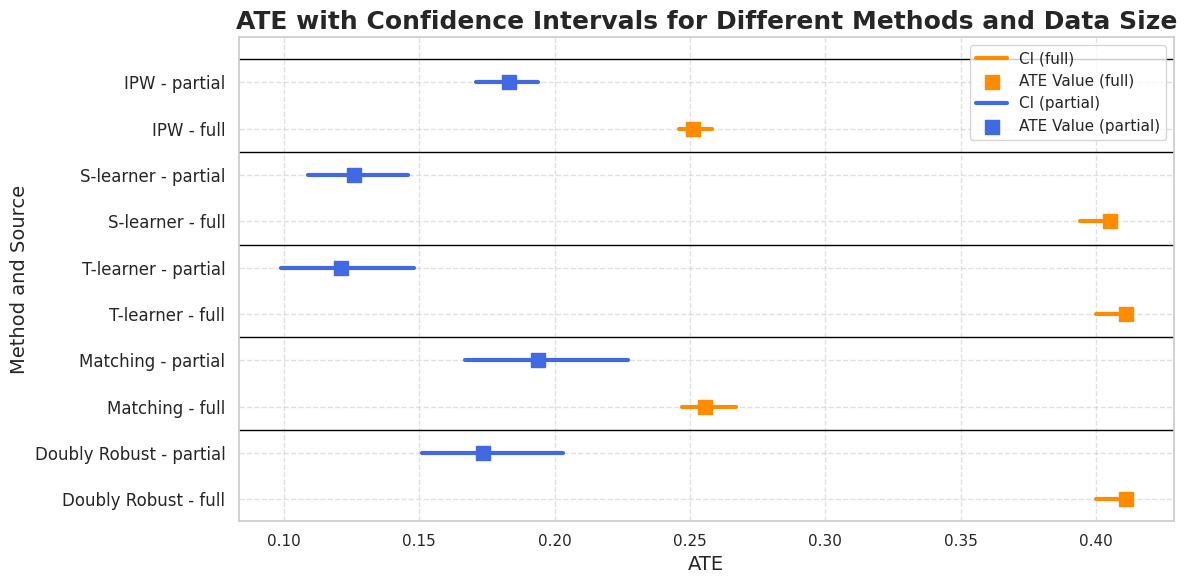

In [25]:
ate_full_df['Source'] = 'full'
ate_partial_df['Source'] = 'partial'
combined_df = pd.concat([ate_full_df, ate_partial_df], ignore_index=True)
combined_df.set_index(['Method', 'Source'], inplace=True)
ordered_methods = reversed(['IPW', 'S-learner', 'T-learner', 'Matching', 'Doubly Robust'])
combined_df = combined_df.loc[
    pd.MultiIndex.from_product([ordered_methods, ['full', 'partial']])
]

sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))

ci_full_label_added = False
ate_full_label_added = False
ci_partial_label_added = False
ate_partial_label_added = False

for i, (index, row) in enumerate(combined_df.iterrows()):
    method, source = index
    ate_value = row['ATE']
    lower_ci, upper_ci = ast.literal_eval(row['CI'])
    
    if source == 'full':
        color = 'darkorange'
    else:
        color = 'royalblue'

    if source == 'full' and not ci_full_label_added:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3, label=f'CI ({source})')
        ci_full_label_added = True
    elif source == 'partial' and not ci_partial_label_added:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3, label=f'CI ({source})')
        ci_partial_label_added = True
    else:
        plt.plot([lower_ci, upper_ci], [i, i], color=color, lw=3) 
    
    if source == 'full' and not ate_full_label_added:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5, label=f'ATE Value ({source})')  
        ate_full_label_added = True
    elif source == 'partial' and not ate_partial_label_added:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5, label=f'ATE Value ({source})')  
        ate_partial_label_added = True
    else:
        plt.scatter(ate_value, i, color=color, marker='s', s=100, zorder=5) 

    if i % 2 == 1:
        plt.axhline(y=i + 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.title('ATE with Confidence Intervals for Different Methods and Data Size', fontsize=18, fontweight='bold')
plt.xlabel('ATE', fontsize=14)
plt.ylabel('Method and Source', fontsize=14)
yticks = range(len(combined_df))
yticklabels = [f'{method} - {source}' for method, source in combined_df.index]
plt.yticks(yticks, yticklabels, fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()